In [1]:
from profiler.core import *

In [2]:
pf = Profiler(workers=2, verbose=False, tol=0.01, eps=0.1)

In [3]:
#pf.session.load_data(name='flights', src='file', fpath='/Users/zhihan/Documents/bart/data/clean_data/flights.csv', embedtxt=False)
pf.session.load_data(name='hospital', src='file', fpath='data/hospital.csv', embedtxt=False)

INFO:profiler.utility:[0.00557398796081543] Load Data start

INFO:profiler.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "Address2": "categorical",
    "Address3": "categorical",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'ProviderNumber': ['equal'], 'HospitalName': ['equal'], 'Address1': ['equal'], 'Address2': ['equal'], 'Address3': ['equal'], 'City': ['equal'], 'State': ['equal'], 'ZipCode': ['equal'], 'CountyName': ['equal'], 'PhoneNumber': ['equal'], 'Hospit

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.dataset:updated types of State to 'text'
INFO:profiler.dataset:updated operators of State to ['equal']
INFO:profiler.dataset:updated types of EmergencyService to 'text'
INFO:profiler.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.dataset:updated types of Score to 'numeric'
INFO:profiler.dataset:updated operators of Score to ['equal']
INFO:profiler.dataset:updated types of Sample to 'numeric'
INFO:profiler.dataset:updated operators of Sample to ['equal']
INFO:profiler.dataset:updated inferred operators of attributes: {'ProviderNumber': ['equal'], 'Hospi

In [5]:
# TODO save embedding vectors
# pf.session.load_embedding()

In [6]:
pf.session.load_training_data()

INFO:profiler.utility:[0.1343381404876709] Create Training Data start

INFO:profiler.transformer:needs multiplier = 54 to bound the error in inv cov estimation <= 0.10000000
INFO:profiler.transformer:use multiplier = 54, and the bound is 0.00024939
INFO:profiler.transformer:Draw Pairs
100%|██████████| 19/19 [00:00<00:00, 194.23it/s]
INFO:profiler.transformer:Number of training samples: 56943
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0283
INFO:profiler.utility:[0.6506938934326172] Create Training Data execution time: 0.5163557529449463



In [7]:
# pf.session.learn_structure(sparsity=0.1)
s = pf.session.struct_engine
data = pf.session.training_data
s.n = pf.session.sample_size

In [8]:
s.est_cov = s.estimate_covariance(data.values, pf.session.null_pb, data.columns)

In [9]:
s.param['sparsity'] = 0.1
s.inv_cov = s.estimate_inverse_covariance(s.est_cov.values, data.columns)

INFO:profiler.graph:use threshold 0.0584


<Figure size 1000x800 with 2 Axes>

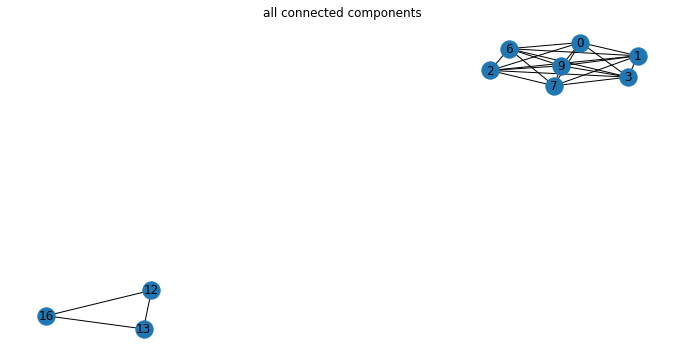

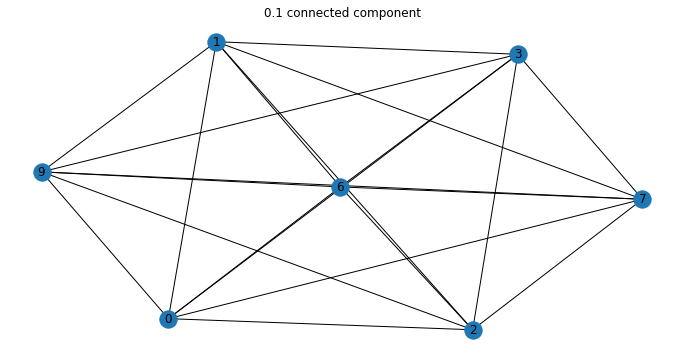

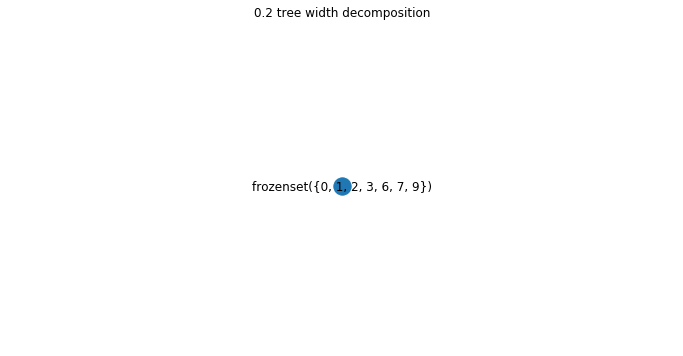

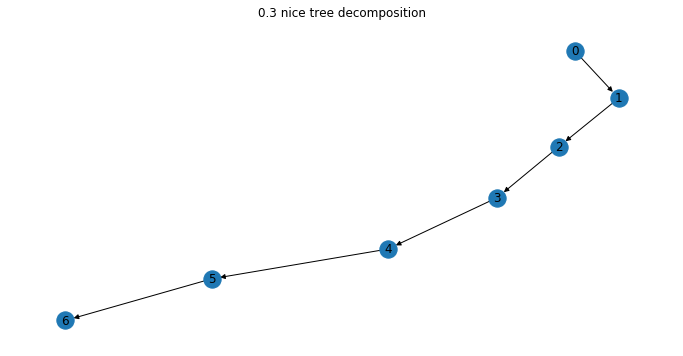

[0]introduce:frozenset({0, 1, 2, 3, 6, 7, 9})
--[1]introduce:frozenset({1, 2, 3, 6, 7, 9})
----[2]introduce:frozenset({2, 3, 6, 7, 9})
------[3]introduce:frozenset({9, 3, 6, 7})
--------[4]introduce:frozenset({9, 6, 7})
----------[5]introduce:frozenset({9, 7})
------------[6]leaf:frozenset({9})
check node t = 0 with X(t) = frozenset({0, 1, 2, 3, 6, 7, 9}) 
check node t = 1 with X(t) = frozenset({1, 2, 3, 6, 7, 9}) 
check node t = 2 with X(t) = frozenset({2, 3, 6, 7, 9}) 
check node t = 3 with X(t) = frozenset({9, 3, 6, 7}) 
check node t = 4 with X(t) = frozenset({9, 6, 7}) 
check node t = 5 with X(t) = frozenset({9, 7}) 
R for leaf node t = 6 with X(t) = frozenset({9}) candidate size: 1
[({9: (1, 2, 3, 6, 7)}, {1: [9], 2: [9], 3: [9], 6: [9], 7: [9]}, -0.9847098867277366)]
R for intro node t = 5 with X(t) = frozenset({9, 7}) candidate size: 1
[({7: (1, 2, 3, 6), 9: (1, 2, 3, 6, 7)}, {1: [9, 7], 2: [9, 7], 3: [9, 7], 6: [9, 7], 7: [9], 0: [7]}, -2.3439932167720228)]
R for intro node t =

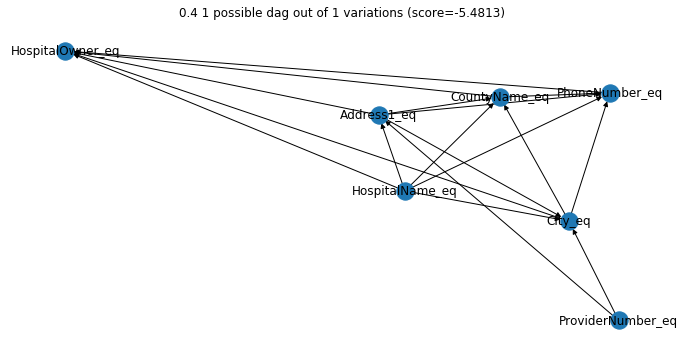

In [10]:
Rs = s.recover_dag()

In [12]:
for i, r in enumerate(Rs[0]):
    print("\n\ncandidate %d"%i)
    print(r)
    s.construct_dag_from_record(r)



candidate 0
({0: set(), 1: set(), 2: (0, 1), 3: (0, 1, 2), 6: (1, 2, 3), 7: (1, 2, 3, 6), 9: (1, 2, 3, 6, 7)}, {1: [9, 7, 6, 3, 2], 2: [9, 7, 6, 3], 3: [9, 7, 6], 6: [9, 7], 7: [9], 0: [7, 6, 3, 2, 1], 9: [0]}, -5.481280204455158)
[] -> ProviderNumber_eq
[] -> HospitalName_eq
[ProviderNumber_eq, HospitalName_eq] -> Address1_eq
[ProviderNumber_eq, HospitalName_eq, Address1_eq] -> City_eq
[HospitalName_eq, Address1_eq, City_eq] -> CountyName_eq
[HospitalName_eq, Address1_eq, City_eq, CountyName_eq] -> PhoneNumber_eq
[HospitalName_eq, Address1_eq, City_eq, CountyName_eq, PhoneNumber_eq] -> HospitalOwner_eq
